# __*Use Darts to predict using past covariates data*__

## __*Install packages*__

### *The basis* for this file is "DARTS_past-covariates.ipynb"

In [83]:
!pip install -q torch
!pip install -q darts
!pip install -q torchmetrics


### __*Imports*__

In [84]:
from torchmetrics.regression import MeanSquaredError
import torch
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae, mse
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [85]:
# !pip install yfinance


### __*Import some example data from yfinance*__

In [86]:
# import yfinance as yf
# import pandas as pd

# # List of stock symbols
# stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

# # Set the start and end dates
# start_date = '2022-01-01'
# end_date = '2023-01-01'

# # Retrieve hourly data for each stock
# dfs = []
# for stock in stocks:
#     # Download data
#     stock_data = yf.download(stock, start=start_date, end=end_date, interval='1h')

#     # Select only the 'Close' column
#     stock_data = stock_data['Close']

#     # Rename the column to the stock symbol
#     stock_data = stock_data.rename(stock)

#     # Add to the list of DataFrames
#     dfs.append(stock_data)

# # Concatenate DataFrames along the columns
# df = pd.concat(dfs, axis=1)


In [87]:
df = pd.DataFrame(pd.read_csv('../raw_data/final_dataset.csv'))


In [88]:
df['date_time'] = pd.to_datetime(df['TimeStamp'])
df.drop(columns=['TimeStamp'], inplace=True)
df.set_index(['date_time'], inplace=True)
df.head()


,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,TEMPERATURE_MORNING_C,...,WINDTEMP_MAX_C,UV_INDEX,TEMPERATURE_NIGHT_C,month_sin,month_cos,sunrise_time_sin,sunrise_time_cos,sunset_time_sin,sunset_time_cos,opinion
date_time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,...,0.0,1.0,2.0,0.5,0.866025,0.75471,-0.656059,-0.971342,-0.237686,0.0
2021-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-1.0,2.0,...,1.0,1.0,3.0,0.5,0.866025,0.75471,-0.656059,-0.972370,-0.233445,0.0
2021-01-02 08:20:00,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
2021-01-02 09:00:00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
2021-01-02 09:20:00,14.0,18.0,0.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0


In [89]:
df_sales = df[['traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat', 'baguette', 'banette', 'cereal_baguette']]
df_sales


,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
date_time,,,,,,,
2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02 08:20:00,0.0,0.0,0.0,3.0,1.0,0.0,0.0
2021-01-02 09:00:00,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2021-01-02 09:20:00,14.0,18.0,0.0,6.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...
2022-09-30 17:20:00,2.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-09-30 17:40:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-09-30 18:00:00,7.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
df_sales[df_sales['traditional_baguette'] < 0]


,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
date_time,,,,,,,
2022-06-02 13:00:00,-2.0,0.0,0.0,0.0,2.0,0.0,0.0


In [91]:
df_sales.describe()


,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
count,15125.000000,15125.000000,15125.00000,15125.000000,15125.000000,15125.000000,15125.000000
mean,7.766149,1.960595,1.55405,1.668496,1.458050,1.502942,0.491041
std,8.829312,4.248609,2.17033,3.487745,2.238678,2.340708,1.164471
min,-2.000000,-3.000000,-1.00000,-3.000000,-1.000000,-2.000000,-3.000000
25%,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,1.00000,0.000000,1.000000,1.000000,0.000000
75%,10.000000,2.000000,2.00000,2.000000,2.000000,2.000000,0.000000
max,98.000000,54.000000,37.00000,46.000000,44.000000,28.000000,15.000000


### __*Convert the pandas dataframe in a darts timeseries object (we need a datetime index!)*__

In [92]:
# Convert the DataFrame to a Darts TimeSeries
# Index must be datetimeindex
timeseries = TimeSeries.from_dataframe(df_sales, fill_missing_dates=True, freq='20min', fillna_value=0)


In [93]:
timeseries.head()


<TimeSeries (DataArray) (date_time: 5, component: 7, sample: 1)>
array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2021-01-01 ... 2021-01-01T01:20:00
  * component  (component) object 'traditional_baguette' ... 'cereal_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Scale the data using the Darts sklearn wrapper*__

In [94]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)
target_transformer = Scaler(scaler)


In [95]:
scaled_ts = ts_transformer.fit_transform(timeseries)
target_transformer = target_transformer.fit(timeseries['traditional_baguette'])


In [96]:
scaled_ts


<TimeSeries (DataArray) (date_time: 45921, component: 7, sample: 1)>
array([[[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
...
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.08      ],
        [0.05263158],
        [0.05263158],
        ...,
        [0.02222222],
        [0.1       ],
        [0.44444444]],

       [[0.09      ],
        [0.05263158],
        [0.10526316],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2021-01-01 ... 2022-09-30T18:40:00
  * component  (component) object 'traditional_baguette' ... 'cereal_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Handle missing values if you have*__
### __*(in this example, weekends are not available since we are dealing with stock markets)*__

In [97]:
from darts.utils.missing_values import fill_missing_values
scaled_ts = fill_missing_values(scaled_ts)
scaled_ts


<TimeSeries (DataArray) (date_time: 45921, component: 7, sample: 1)>
array([[[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
...
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.08      ],
        [0.05263158],
        [0.05263158],
        ...,
        [0.02222222],
        [0.1       ],
        [0.44444444]],

       [[0.09      ],
        [0.05263158],
        [0.10526316],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2021-01-01 ... 2022-09-30T18:40:00
  * component  (component) object 'traditional_baguette' ... 'cereal_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Train Test Split*__

<Axes: xlabel='date_time'>

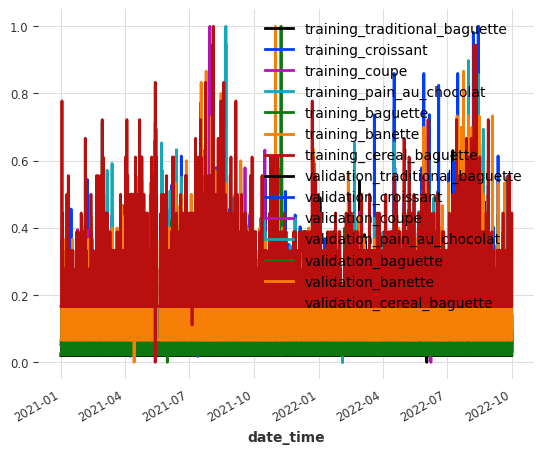

In [98]:
train, val = (scaled_ts).split_before(0.8)# (we standardize by dividing by 100 since Google Trends data tops out at 100 by default!)
train.plot(label="training")
val.plot(label="validation")


### __*Advanced multicovariate RNN training*__

### __*Setup Earlystopping and the train on GPU*__

In [99]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
es = EarlyStopping(
    monitor="val_loss",
    patience=20,
    min_delta=0.01,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [es],
                   "accelerator": "cpu"}


### __*Instanciate our model*__

In [100]:
# predict 7 days considering the latest 28 days
days_predict = 7
t_predict = days_predict*72
days_for_prediction =-28*72


model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=abs(days_for_prediction),
    output_chunk_length=t_predict,
    dropout=0.2,
    torch_metrics=MeanSquaredError(),
    n_epochs=1,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
)


In [101]:
train['traditional_baguette']


<TimeSeries (DataArray) (date_time: 36736, component: 1, sample: 1)>
array([[[0.02]],

       [[0.02]],

       [[0.02]],

       ...,

       [[0.02]],

       [[0.02]],

       [[0.02]]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2021-01-01 ... 2022-05-26T05:00:00
  * component  (component) object 'traditional_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Train the model*__

In [102]:
model_pastcov.fit(
    series=[train['traditional_baguette']],    # the target training data
    past_covariates=train,     # the multi covariate features training data
    val_series=[val['traditional_baguette']],  # the target validation data
    val_past_covariates=val,   # the multi covariate features validation data
    verbose=True,
)


Epoch 0: 100%|██████████| 1070/1070 [19:00<00:00,  0.94it/s, train_loss=0.00193, val_loss=0.00585, val_MeanSquaredError=0.00585, train_MeanSquaredError=0.00325]


BlockRNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.2, input_chunk_length=2016, output_chunk_length=504, torch_metrics=MeanSquaredError(), n_epochs=1, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fe827561180>], 'accelerator': 'cpu'}, random_state=0)

### __*Do a prediction*__

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


<Axes: xlabel='date_time'>

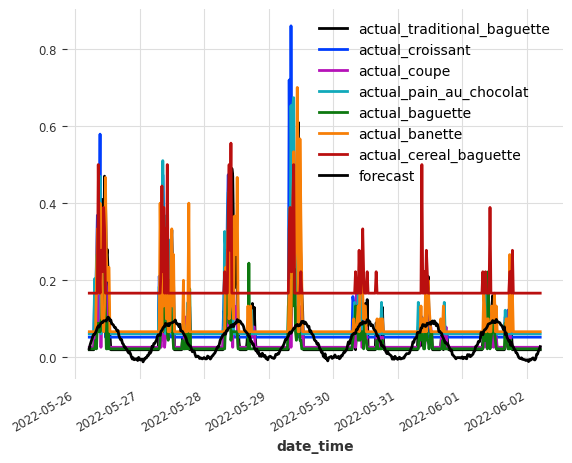

In [107]:
pred_cov = model_pastcov.predict(n=t_predict,                        # n of days to predict
                                 series=train['traditional_baguette'][days_for_prediction:],  # target input for prediction
                                 past_covariates=train[days_for_prediction:]) # past-covariates input for prediction

val[:t_predict].plot(label="actual")
pred_cov.plot(label="forecast")


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


<Axes: xlabel='date_time'>

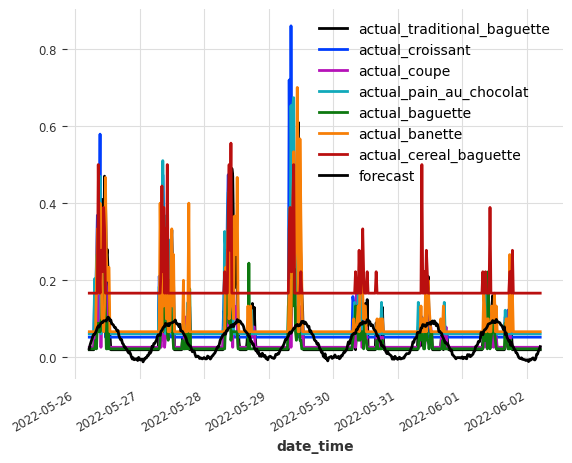

In [108]:
days_predict = 7
t_predict = days_predict*72
days_for_prediction =-28*72

pred_cov = model_pastcov.predict(n=t_predict,                        # n of days to predict
                                 series=train['traditional_baguette'][days_for_prediction:],  # target input for prediction
                                 past_covariates=train[days_for_prediction:]) # past-covariates input for prediction

val[:t_predict].plot(label="actual")
pred_cov.plot(label="forecast")


### __*Check the metrics*__

In [111]:
# check the SMAPE error

smape(val['traditional_baguette'][:7], pred_cov)


65.09630605376971

### __*Extract the predictions as np array in the original scale*__

In [112]:
target_transformer.inverse_transform(pred_cov).values()


array([[ 0.28224665],
       [ 1.3340479 ],
       [ 2.05718365],
       [ 2.74854671],
       [ 3.52706681],
       [ 3.99233343],
       [ 4.03402293],
       [ 4.4567325 ],
       [ 5.02540517],
       [ 5.74724828],
       [ 6.16038821],
       [ 5.87047705],
       [ 6.4664234 ],
       [ 6.8487721 ],
       [ 7.09761308],
       [ 7.09015069],
       [ 7.50331696],
       [ 7.50801137],
       [ 7.49333811],
       [ 7.43261851],
       [ 8.08764122],
       [ 8.45941239],
       [ 8.23215047],
       [ 7.50341035],
       [ 7.70982021],
       [ 6.71967012],
       [ 6.60659983],
       [ 6.35043251],
       [ 5.82606258],
       [ 5.78852575],
       [ 5.30795645],
       [ 4.88682736],
       [ 4.97771777],
       [ 3.67639339],
       [ 3.0534272 ],
       [ 2.56105791],
       [ 2.63903904],
       [ 1.66203735],
       [ 1.40726062],
       [ 0.69842571],
       [ 0.73173528],
       [ 0.23645679],
       [ 0.03796608],
       [-0.51788273],
       [-0.8510096 ],
       [-0